In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import numpy as np
import matplotlib.pyplot as plt
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'] , dataset['test']

> İlk satırda kullanılan **as_supervised** True olduğunda veri seti 2 dizili bir yapıya (giriş,etiket) sahip olacaktır, eğer bu False olur ise veri seti tüm özellikleri içeren bir sözlüğe sahip olacaktır.

> **with_info** True olduğunda veri seti ile ilgili bilgileri döndürür.

> 2.kod satırı ise eğitim verisini train ve test olarak ayırmamızı sağlamaktadır.Veri seti içerisinde train,test bulunduğu için direkt olarak ayırma işlemi yapabilmekteyiz

In [3]:
class_names = metadata.features['label'].names
print('Resim Etiketleri : {}'.format(class_names))

Resim Etiketleri : ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
train_set_example = metadata.splits['train'].num_examples
test_set_example = metadata.splits['test'].num_examples
print('Eğitim Setindeki Örnek Sayısı : ', train_set_example)
print('Test Setindeki Örnek Sayısı: ', test_set_example)

Eğitim Setindeki Örnek Sayısı :  60000
Test Setindeki Örnek Sayısı:  10000


In [5]:
def normalize(images,labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images,labels

> Normalleştirme fonksiyonu içerisine resim ve etiket almaktadır, bu fonksiyona giren resimler ilk önce tf.float32 tipine çevrilmekte daha sonra ise her pixeli 255'e bölünerek 0 ile 1 arasında değere dönüştürülmektedir. Fonksiyon resim ve etiketi geri döndürmektedir.

In [6]:
train_dataset= train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

> Yukarıdaki kod satırlarında bulunan .map işlevi her elemana işlevi uygulamak için kullanılır yani ilk satıra bakılacak olursa train_dataset içerisinde bulunan her eleman normalleştirme fonksiyonuna girmiş demektir.

In [7]:
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

> Veri kümesi ilk kez kullanıldığında görüntüler disk üzerinden yüklenmektedir, yukarıda yapılan işlem görüntüleri önbelleğe almaktadır. Bu sayede eğitim daha hızlı hale gelir.

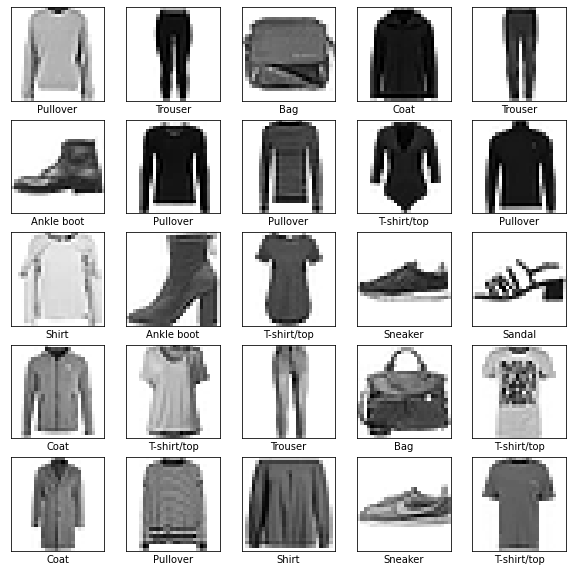

In [8]:
plt.figure(figsize= (10,10)) #10,10 büyüklüğünde pencere oluştur

for i, (image,label) in enumerate(train_dataset.take(25)): #eğitim setinden 25 örnek al
  image = image.numpy().reshape((28,28)) #resmi 28x28'e çevir
  plt.subplot(5,5,i+1) #5e 5'lik ızgara oluştur
  plt.xticks([]) #x kısmı çizelge boş
  plt.yticks([]) #y kısmı boş(çizelge örn 0.1.2.3.4.5 vs.)
  plt.grid(False) #kılavuz(yardımcı) çizgiler yok
  plt.imshow(image, cmap = plt.cm.binary) #resimleri binary formatında göster
  plt.xlabel(class_names[label]) # x ekseninde labellar

plt.show() #pencereyi göster

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

> **Flatten** katmanı giriş katmanıdır, görüntüleri düzleştirmek için vardır herhangi birşey öğrenmez. Resimleri 28,28,1 formatından 784 piksellik bir 1 boyutlu diziye dönüştürür. Bu katman yalnızca verileri düzleştirir.

> Gizli katman 128 adet nörona sahip aktivasyon fonksiyonu relu olan katmandır. Bu katman birbirine yoğun olarak bağlıdır.(hepsi bağlı) Önceki katmandaki 784 düğümün tümünden giriş alır ve bu girişi eğitim sırasında öğrenilecek gizli parametrelere göre ağırlık verir ve bir sonraki katmana tek bir değer verir. 

> Çıkış katmanı 10 adet nörondan oluşmaktadır. Her düğüm bir sınıfı temsil etmektedir(etiketi) Aktivasyon fonksiyonu softmax fonksiyonudur. Her düğüm 0 ile 1 arasında bir değer üretir, bu değer o etikete ait olma olasılığıdır. Olasılıkların yani her nöronun ürettiği değerlerin toplamı 1'dir.

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

> Burada optimizer , loss ve metrics belirtilerek model derlenmiştir. Optimizer ve loss kavramlarından daha önce bahsedilmişti, metrics kavramı eğitim ve test adımlarını izleme olarak düşünülebilir. Accuracy olarak belirtilmesi doğru şekilde sınıflandırılan resimlerin oranını belirteceğini gösterir.

In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(train_set_example).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)


> Eğitim setindeki her verinin sırası shuffle argümanı ile karıştırılmış ve modelin örnek sırasından birşey öğrenmesinin önüne geçilmiştir, batch size ise tek seferde alınacak resim sayısıdır.32 adet resmi toplu olarak gruplar.Eğitim süresinin hızlandırılmasını sağlar. Repeat belirtilmesi ise sonsuza kadar yineleneceği anlamına gelmektedir. Sonlandırılması epochs ile belirtilecektir.

In [12]:
model.fit(train_dataset,
          epochs=5,
          steps_per_epoch=math.ceil(train_set_example/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 26s 6ms/step - loss: 0.4928 - accuracy: 0.8266
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3757 - accuracy: 0.8644
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3312 - accuracy: 0.8792
Epoch 4/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.3096 - accuracy: 0.8871
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2890 - accuracy: 0.8937


In [13]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(test_set_example/32))
print('Test Seti Üzerindeki Doğruluk: ', test_accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 0.3468 - accuracy: 0.8776
Test Seti Üzerindeki Doğruluk:  0.8776000142097473


> model.evaluate fonksiyonu model üzerindeki doğruluğu denetlemek için kullanılır.

In [14]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

#test veri seti üzerinden örnek alımı ve tahmin işlemi yapılması

In [15]:
predictions.shape

(32, 10)

> Daha önce batch size 'ı 32 olarak belirtmiştik. Test veri setinden 1 örnek almak istediğimizde toplam 32 örnek döndürmesi artık veri setlerimizi toplulaştırdığımızdan kaynaklanmaktadır. 

In [16]:
print('İlk görüntü için tahmin : ', predictions[0])

İlk görüntü için tahmin :  [1.5393876e-04 1.0000740e-04 2.3436645e-02 1.9488627e-05 8.8083690e-01
 1.1058372e-06 9.5418595e-02 1.4185412e-06 3.1698302e-05 9.2524580e-08]


In [17]:
print('İlk görüntünün tahmindeki sınıfı : ',np.argmax(predictions[0]))

İlk görüntünün tahmindeki sınıfı :  4


In [18]:
print('İlk görüntünün gerçek sınıfı : ', test_labels[0])

İlk görüntünün gerçek sınıfı :  4


In [19]:
#test verisetinden bir görüntü alınması
img = test_images[0]
print(img.shape)

(28, 28, 1)


In [20]:
#toplulaştırma işlemi
img = np.array([img])
print(img.shape)

(1, 28, 28, 1)


In [21]:
predictions_single = model.predict(img)

print("Tahminler : ", predictions_single)

Tahminler :  [[1.5393879e-04 1.0000713e-04 2.3436636e-02 1.9488647e-05 8.8083702e-01
  1.1058384e-06 9.5418513e-02 1.4185399e-06 3.1698306e-05 9.2524417e-08]]


In [22]:
np.argmax(predictions_single[0])

4

In [23]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

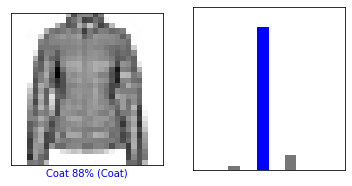

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

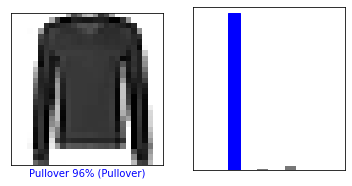

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

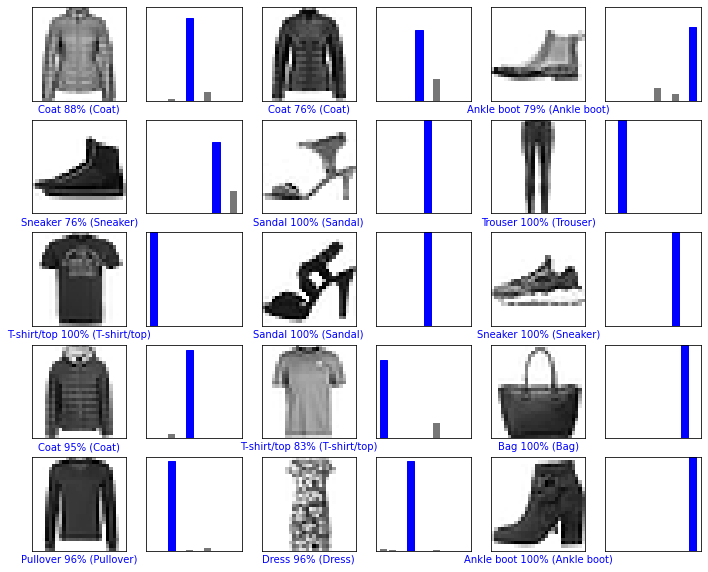

In [26]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)